In [1]:
using FileIO, DelimitedFiles, HDF5
using Plots, Rsvg, LaTeXStrings
using LinearAlgebra, Statistics
using JUMD, Chemfiles
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

Plots.PyPlotBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "2w9y"
# Leo modos
modes_2w9y, evals_2w9y = JUMD.readPtrajModes(
    joinpath(home, pdb,  "pca", string("full_modes_", pdb)))
# AAs
aa3 = convert(Int64, length(evals_2w9y))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_2w9y = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_2w9y = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_2w9y = (ndd_out_2w9y .- vol_avg_2w9y) .* evals_2w9y
vgv_2w9y = vgv_2w9y ./ norm(vgv_2w9y);

## Volumen de la trayectoria

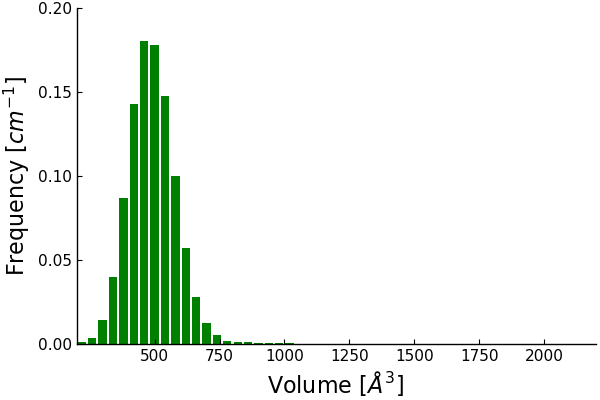

In [3]:
st = 40
bin_vol = collect(200:st:1200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_2w9y, Whis_vol_2w9y = JUMD.WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_2w9y, Whis_vol_2w9y,
    xlims = (200, 2200), ylims = (0, .2),
    xticks = 500:250:2000,
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ",
    linecolor = false, fillcolor = Colors.colorant"#008000",
    legend = false)

In [62]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "1", string("1_vol_", pdb, ".svg")))

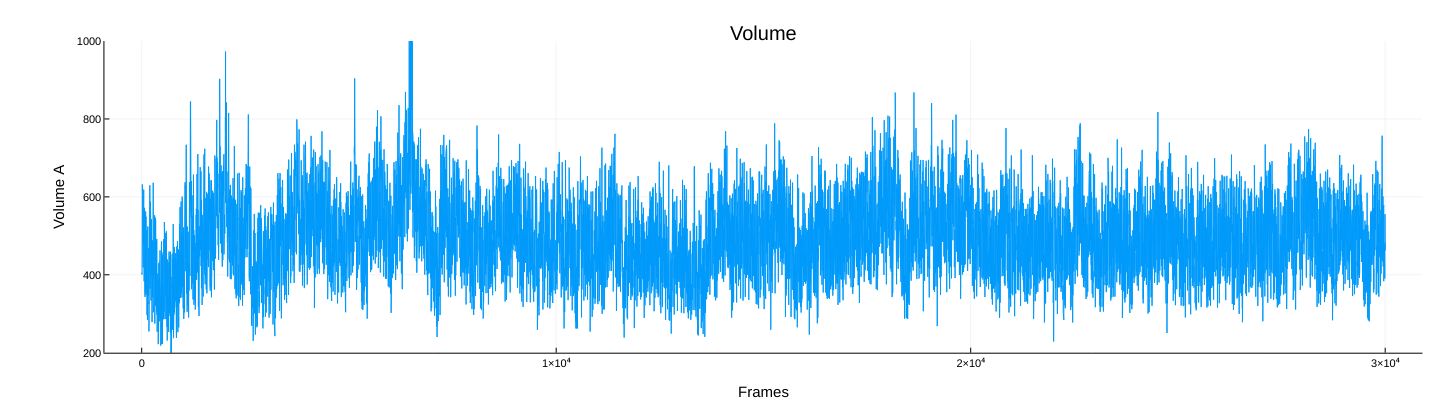

In [14]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    ylims = (200, 1000),
    legend = false, size = (750, 400))

In [4]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 491.29946563333334
  88.4187380575453 

## Energía

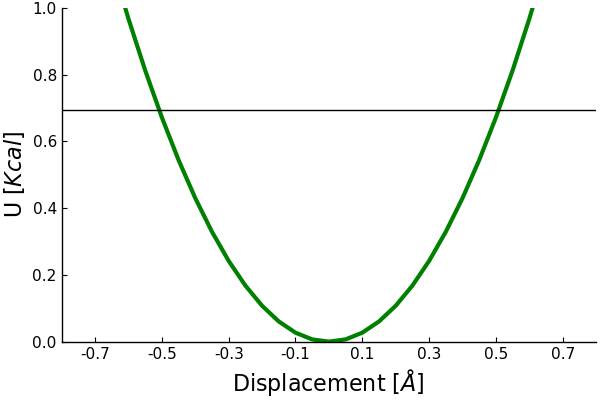

In [59]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_2w9y = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_2w9y[i] = JUMD.energia_gdte(evals_2w9y, vgv_2w9y, d)
end

plt_u = plot(pasos, E_2w9y,
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8), ylims = (0, 1.),
    grid = false, guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = L"U $[Kcal]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#008000", linewidth = 3,
    legend = false)

hline!([RT], linecolor = Colors.colorant"black")

In [60]:
savefig(plt_u, joinpath(rtdos, "papel", "7", string("7_U_", pdb, ".svg")))

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(7:132))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

### Obtengo proyecciones de PCA sobre trayectoria

In [5]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_2w9y = Array{Float64, 1}(undef, nframes)
prj_2_2w9y = Array{Float64, 1}(undef, nframes)
prj_3_2w9y = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 1])
    prj_2_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 2])
    prj_3_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 3])
end

# Smooth
smooth_prj_1_2w9y = [ mean(prj_1_2w9y[i:i+9]) for i = 1:10:length(prj_1_2w9y)-9 ]
smooth_prj_2_2w9y = [ mean(prj_2_2w9y[i:i+9]) for i = 1:10:length(prj_2_2w9y)-9 ]
smooth_prj_3_2w9y = [ mean(prj_3_2w9y[i:i+9]) for i = 1:10:length(prj_3_2w9y)-9 ];

In [8]:
using Makie

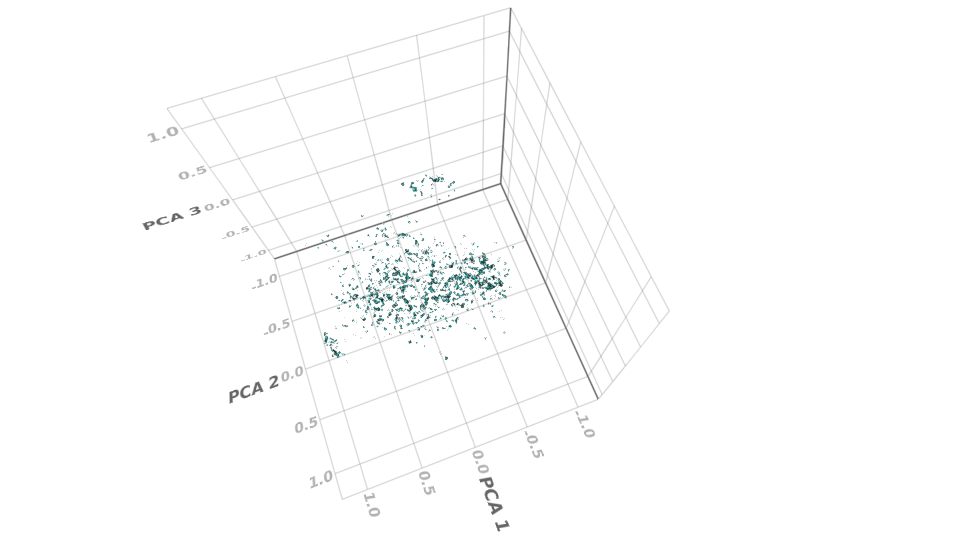

In [11]:
xyz_bins = collect(-1:.025:1)

his_ind, his = JUMD.HisInd3D(smooth_prj_1_2w9y, smooth_prj_2_2w9y, smooth_prj_3_2w9y,
    xyz_bins, xyz_bins, xyz_bins)

cuentas = 2
msk = his .> cuentas
main_his = his[msk]
main_his_ind = his_ind[msk];

sc = Makie.volume(convert(Array{Float64,3}, msk), algorithm = :iso)
sc[Axis][:names, :axisnames] = ("PCA 1", "PCA 2", "PCA 3")

tck_lab = string.(collect(-1.:.5:1.))
sc[Axis][:ticks][:labels] = (tck_lab, tck_lab, tck_lab)

eyepos = Vec3f0(50, 120, 230)
lookat = Vec3f0(10, 15, -35)
update_cam!(sc, eyepos, lookat)
sc

In [12]:
Makie.save(joinpath(rtdos, string("3D_", pdb, ".png")), sc)

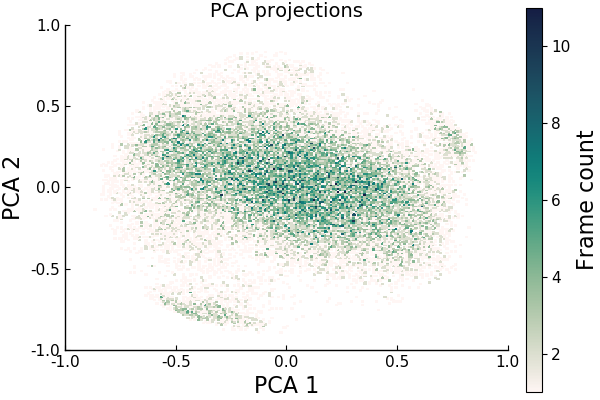

In [6]:
plt_2his = histogram2d(smooth_prj_1_2w9y, smooth_prj_2_2w9y,
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "PCA projections",
    colorbar_title = "Frame count",
    nbins = 200, seriescolor = :tempo, grid = false)

In [83]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("2_PCAHis_", pdb, ".svg")))

In [23]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

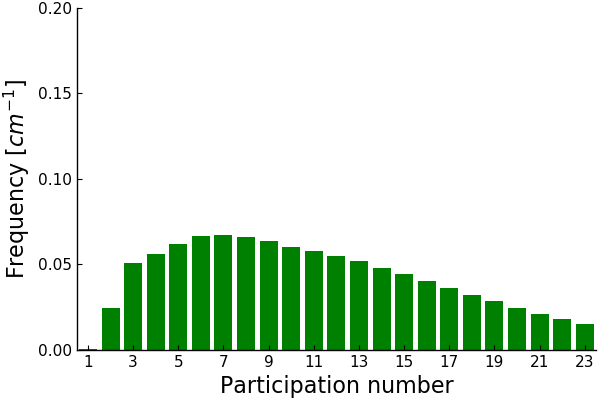

In [97]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#008000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Participation number",
    legend = false, grid = false)

In [98]:
savefig(plt_his_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

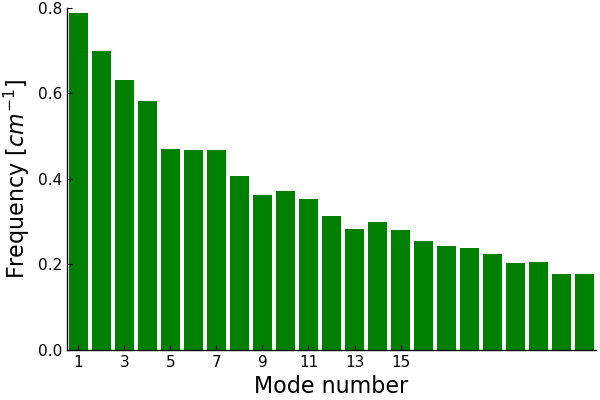

In [95]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.WeightedHist(flat_marcos_modos,
    bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:15, yticks = 0:.2:.8,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#008000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Mode number",
    legend = false, grid = false)

In [96]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))